### **Import Libraries**


In [1]:
import os

import albumentations
import numpy as np
import pytorch_lightning as pl
import torch
import wandb
from albumentations.pytorch import ToTensorV2
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from torchmetrics.classification import (
    Accuracy,
    ConfusionMatrix,
    F1Score,
    Precision,
    Recall,
)
from torchvision import datasets
from torchvision.models import convnext_base, resnet50, vgg16, vit_b_16, swin_b
from torchvision.datasets.utils import check_integrity, download_url
import pickle
import tarfile
from torch.utils.data import Dataset
from typing import ClassVar, Optional
import torchvision
from PIL import Image
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image
import matplotlib.pyplot as plt



### **Tomato Leaf Disease Dataset**


In [2]:
class Bent(Dataset):
    """
    A PyTorch dataset for the BENT data.

    :param data: The data tensor.
    :type data: torch.Tensor

    :param target: The target tensor.
    :type target: torch.Tensor
    """

    base_folder = "batches"
    url = "https://drive.google.com/file/d/1s3u9HKXCJmX_1DKv5Hp9fJS_b5DyfNHV"
    filename = "bent_batches.tar.gz"
    tgz_md5 = "b0f93db1d28dad0561da6f16243b1766"
    train_list: ClassVar[list] = [
        ["data_batch_0", "50d49ca1d3da4adab4a9995789524297"],
        ["data_batch_1", "c5b99ce3457651013f48bbf894ed03f5"],
        ["data_batch_2", "8fb2c8c90d295babb317ca8df93e6bbe"],
        ["data_batch_3", "858178ae4b2facd6234efa1d7eb5cd42"],
        ["data_batch_4", "c6431b63801c69959dbd66a2e0c0e806"],
        ["data_batch_5", "8ae7d9b4492b1e52f766dbeed0d3a02c"],
        ["data_batch_6", "43a5cf61c3a8b314d3dece7043e94d56"],
        ["data_batch_7", "8a45db626670e50e2aebd75b0bf35b4a"],
        ["data_batch_8", "4511c9175d861e75e00e0bea968c586a"],
    ]

    test_list: ClassVar[list] = [["test_batch", "559a2d8336d673f1025a8682a91a4914"]]

    meta: ClassVar[dict] = {
        "filename": "batches.meta",
        "key": "labels",
        "md5": "214499a9b09597e8cbb6cd951debe1cc",
    }

    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[torchvision.transforms.Compose] = None,
        target_transform: Optional[torchvision.transforms.Compose] = None,
        download: bool = False,
        include_small: bool = False,
    ) -> None:
        """
        Initialize the BENT dataset.

        :param root: The root directory of the dataset.
        :type root: str
        :param train: If True, creates a dataset from the training set, otherwise from the test set.
        :type train: bool
        :param transform: A function/transform that takes in an PIL image and returns a transformed version.
        :type transform: Optional[torchvision.transforms.Compose]
        :param target_transform: A function/transform that takes in the target and transforms it.
        :type target_transform: Optional[torchvision.transforms.Compose]
        :param download: If True, downloads the dataset from the internet and puts it in root directory.
        :type download: bool
        :param include_small: If True, includes the small dataset.
        :type include_small: bool
        """
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.include_small = include_small

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError(
                "Dataset not found or corrupted. You can use download=True to download it."
            )  # noqa: TRY003

        downloaded_list = self.train_list if self.train else self.test_list
        self.data = []
        self.target = []

        for file_name, _ in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)

            with open(file_path, "rb") as infile:
                entry = pickle.load(infile, encoding="latin1")  # noqa: S301

            labels = entry["labels"] if "labels" in entry else entry["fine_labels"]

            for i, label in enumerate(labels):
                if not self.include_small:
                    if label not in ["101", "201"]:
                        self.data.append(entry["data"][i])
                        label = 0 if label == "100" else 1
                        self.target.append(label)
                    else:
                        continue
                else:
                    print("Including small dataset." + label)
                    self.data.append(entry["data"][i])
                    label = 0 if label in ["100", "101"] else 1
                    self.target.append(label)

        self.data = np.array(self.data).reshape(-1, 1, 150, 150)
        self.data = self.data.transpose((0, 2, 3, 1))

        self._load_meta()

    def _load_meta(self) -> None:
        """
        Load the metadata of the dataset.
        """
        path = os.path.join(self.root, self.base_folder, self.meta["filename"])
        if not check_integrity(path, self.meta["md5"]):
            raise RuntimeError(
                "Dataset metadata not found or corrupted. You can use download=True to download it."
            )  # noqa: TRY003

        with open(path, "rb") as infile:
            data = pickle.load(infile, encoding="latin1")  # noqa: S301
            self.classes = data[self.meta["key"]]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Get an item from the dataset.

        :param index: The index of the item.
        :type index: int

        :return: The data and target tensors.
        :rtype: tuple[torch.Tensor, torch.Tensor]
        """
        img, target = self.data[index], self.target[index]

        img = np.reshape(img, (150, 150))
        img = Image.fromarray(img, mode="L")
        img = Image.merge("RGB", (img, img, img))

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self) -> int:
        """
        Get the length of the dataset.

        :return: The length of the dataset.
        :rtype: int
        """
        return len(self.data)

    def _check_integrity(self) -> bool:
        """
        Check the integrity of the dataset.

        :return: True if the dataset is found and intact, False otherwise.
        :rtype: bool
        """
        root = self.root
        for fentry in self.train_list + self.test_list:
            filename, md5 = fentry
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self) -> None:
        """
        Download the BENT dataset.
        """
        if self._check_integrity():
            print("Files already downloaded and verified")
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)  # noqa: S202

    def __repr__(self) -> str:
        """
        Get the representation of the dataset.

        :return: The representation of the dataset.
        :rtype: str
        """
        fmt_str = "Dataset " + self.__class__.__name__ + "\n"
        fmt_str += f"    Number of datapoints: {self.__len__()}\n"
        tmp = "train" if self.train is True else "test"
        fmt_str += f"    Split: {tmp}\n"
        fmt_str += f"    Root Location: {self.root}\n"
        tmp = "    Transforms (if any): {}\n".format(
            self.transform.__repr__().replace("\n", "\n" + " " * 29)
        )
        fmt_str += tmp
        tmp = "    Target Transforms (if any): {}\n".format(
            self.target_transform.__repr__().replace("\n", "\n" + " " * 29)
        )
        fmt_str += tmp
        return fmt_str


In [3]:
class Transforms:
    def __init__(self, transforms: albumentations.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))["image"]


class GalaxyDataset(pl.LightningDataModule):
    def __init__(
        self,
        data_dir,
        batch_size=32,
        num_workers=4,
        transform=None,
        test_transform=None,
    ):
        super(GalaxyDataset, self).__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
        self.test_transform = test_transform

    def setup(self, stage=None):
        self.train_dataset = Bent(
            root="data/bent",
            download=True,
            train=True,
            transform=Transforms(transforms=self.transform),
            target_transform=None,
            include_small=False,
        )
        self.val_dataset = Bent(
            root="data/bent",
            download=True,
            train=False,
            transform=Transforms(transforms=self.transform),
            target_transform=None,
            include_small=False,
        )
        self.test_dataset = Bent(
            root="data/bent",
            download=True,
            train=False,
            transform=Transforms(transforms=self.test_transform),
            target_transform=None,
            include_small=False,
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers
        )

### **Model Selection**


In [4]:
def select_model(model_name, num_classes):
    if model_name == "resnet50":
        model = resnet50(weights="DEFAULT")
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "vgg16":
        model = vgg16(weights="DEFAULT")
        model.classifier[6] = torch.nn.Linear(
            model.classifier[6].in_features, num_classes
        )
    elif model_name == "convnext_base":
        model = convnext_base(weights="DEFAULT")
        model.classifier[2] = torch.nn.Linear(
            model.classifier[2].in_features, num_classes
        )
    elif model_name == "vit_b_16":
        model = vit_b_16(weights="DEFAULT")
        model.heads = torch.nn.Linear(model.heads.head.in_features, num_classes)
    elif model_name == "swin_b":
        model = swin_b(weights="DEFAULT")
        model.head = torch.nn.Linear(model.head.in_features, num_classes)
    else:
        raise ValueError(f"Unknown model name {model_name}")

    return model

### **Classifier PL Module**


In [5]:
class VisionClassifier(pl.LightningModule):
    def __init__(self, model, num_classes, learning_rate=1e-3):
        super(VisionClassifier, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.criterion = torch.nn.CrossEntropyLoss()

        # Metrics
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

        self.precision = Precision(task="multiclass", num_classes=num_classes)
        self.recall = Recall(task="multiclass", num_classes=num_classes)
        self.f1_score = F1Score(task="multiclass", num_classes=num_classes)
        self.confusion_matrix = ConfusionMatrix(
            task="multiclass", num_classes=num_classes
        )

        self.test_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Log training accuracy
        acc = self.train_accuracy(y_hat, y)
        self.log(
            "train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "train/acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Log validation accuracy and other metrics
        acc = self.val_accuracy(y_hat, y)
        prec = self.precision(y_hat, y)
        rec = self.recall(y_hat, y)
        f1 = self.f1_score(y_hat, y)

        self.log("val/loss", loss, on_epoch=True, logger=True)
        self.log("val/acc", acc, on_epoch=True, prog_bar=True, logger=True)
        self.log("val/precision", prec, on_epoch=True, logger=True)
        self.log("val/recall", rec, on_epoch=True, logger=True)
        self.log("val/f1_score", f1, on_epoch=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Store test outputs for logging at the end of the epoch
        self.test_outputs.append({"y_hat": y_hat, "y": y})

        return loss

    def on_test_epoch_end(self):
        # Combine outputs from the test step
        y_hats = torch.cat([output["y_hat"] for output in self.test_outputs], dim=0)
        y_true = torch.cat([output["y"] for output in self.test_outputs], dim=0)

        # Compute aggregated metrics
        acc = self.test_accuracy(y_hats, y_true)
        precision = self.precision(y_hats, y_true)
        recall = self.recall(y_hats, y_true)
        f1 = self.f1_score(y_hats, y_true)

        # Log these metrics for reporting
        self.log("test/acc", acc, on_epoch=True, logger=True)
        self.log("test/precision", precision, on_epoch=True, logger=True)
        self.log("test/recall", recall, on_epoch=True, logger=True)
        self.log("test/f1_score", f1, on_epoch=True, logger=True)

        # Calculate and log class-wise metrics
        y_true_np = y_true.cpu().numpy()
        y_hats_np = torch.argmax(y_hats, dim=1).cpu().numpy()
        report = classification_report(
            y_true_np,
            y_hats_np,
            target_names=[str(i) for i in range(self.num_classes)],
            zero_division=0,
        )

        # Log the classification report
        self.logger.experiment.log(
            {"classification_report": wandb.Html(f"<pre>{report}</pre>")}
        )

        # Log confusion matrix if needed for visualization in the paper
        self.logger.experiment.log(
            {
                "confusion_matrix": wandb.plot.confusion_matrix(
                    probs=None,
                    y_true=y_true.cpu().numpy(),
                    preds=torch.argmax(y_hats, dim=1).cpu().numpy(),
                    class_names=[str(i) for i in range(self.num_classes)],
                )
            }
        )

        # Save the test probabilities as a tensor file
        test_output = torch.cat(
            [output["y_hat"] for output in self.test_outputs], dim=0
        )
        torch.save(test_output, "test_output.pt")

        # Log the saved file to W&B
        artifact = wandb.Artifact(
            "test_output", type="dataset", description="Test output probabilities"
        )
        artifact.add_file("test_output.pt")
        self.logger.experiment.log_artifact(artifact)

    def configure_optimizers(self):
        if self.model.__class__.__name__ in ["SwinTransformer", "VisionTransformer"]:
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=5, eta_min=0
            )
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=5, gamma=0.1
            )

        return [optimizer], [scheduler]

### **Run Experiments**


In [6]:
# Define hyperparameters
hparams = {
    # Choose from 'resnet50', 'vgg16', 'convnext_base', 'vit_b_16', 'swin_b'
    "model_name": "vit_b_16",
    "learning_rate": 1e-4,
    "batch_size": 32,
    "num_workers": 4,
    "num_classes": 2,
    "max_epochs": 30,
    "train_transform": albumentations.Compose(
        [
            albumentations.Resize(224, 224),
            albumentations.HorizontalFlip(),
            albumentations.Normalize(
                mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
            ),
            ToTensorV2(),
        ]
    ),
    "test_transform": albumentations.Compose(
        [
            albumentations.Resize(224, 224),
            albumentations.Normalize(
                mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
            ),
            ToTensorV2(),
        ]
    ),
}

# Instantiate the data module
data_module = GalaxyDataset(
    data_dir="",
    batch_size=hparams["batch_size"],
    num_workers=hparams["num_workers"],
    transform=hparams["train_transform"],
    test_transform=hparams["test_transform"],
)

# Instantiate the selected model
model = select_model(hparams["model_name"], hparams["num_classes"])

# Instantiate the VisionClassifier Lightning module
vision_classifier = VisionClassifier(
    model=model,
    num_classes=hparams["num_classes"],
    learning_rate=hparams["learning_rate"],
)

# W&B Login
wandb.login(key="af09b7a5fb5f75afd5e00094aa0c7ae8b17e9028")

# Initialize W&B logger with hyperparameters
wandb_logger = WandbLogger(
    name=model.__class__.__name__, project="vision-classifier-galaxy", log_model="all"
)
wandb_logger.experiment.config.update(hparams)  # Save hyperparameters

# Checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="val/acc",
    dirpath="checkpoints",
    filename="vision-classifier-{epoch:02d}-{val/acc:.2f}",
    save_top_k=2,
    mode="max",
)

# Early stopping callback
early_stopping_callback = pl.callbacks.EarlyStopping(
    monitor="val/acc", patience=5, mode="max"
)

# Learning rate monitor
lr_monitor = LearningRateMonitor(logging_interval="step")

# Trainer
trainer = pl.Trainer(
    max_epochs=hparams["max_epochs"],
    logger=wandb_logger,
    callbacks=[checkpoint_callback, lr_monitor, early_stopping_callback],
    accelerator="auto",
    log_every_n_steps=1,
)

# Train the model
trainer.fit(vision_classifier, datamodule=data_module)

# Test the model with the best checkpoint
trainer.test(ckpt_path="best", datamodule=data_module)

# Close
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /teamspace/studios/this_studio/.netrc
wandb: Currently logged in as: mirsazzathossain to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /teamspace/studios/this_studio/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified



  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | model            | VisionTransformer         | 85.8 M | train
1 | criterion        | CrossEntropyLoss          | 0      | train
2 | train_accuracy   | MulticlassAccuracy        | 0      | train
3 | val_accuracy     | MulticlassAccuracy        | 0      | train
4 | test_accuracy    | MulticlassAccuracy        | 0      | train
5 | precision        | MulticlassPrecision       | 0      | train
6 | recall           | MulticlassRecall          | 0      | train
7 | f1_score         | MulticlassF1Score         | 0      | train
8 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.201   Total estimated model params size (MB)
159       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Restoring states from the checkpoint path at /teamspace/studios/this_studio/checkpoints/vision-classifier-epoch=09-val/acc=0.65.ckpt


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/checkpoints/vision-classifier-epoch=09-val/acc=0.65.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.6190476417541504     │
│       test/f1_score       │    0.6190476417541504     │
│      test/precision       │    0.6190476417541504     │
│        test/recall        │    0.6190476417541504     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
lr-AdamW,█▇▆▆▆▆▆▃▃▃▃▃▂▂▂▂▁▁▁▂▂▂▃▃▆▇▇▇▇▇█▇▆▆▃▃▃▂▂▂
test/acc,▁
test/f1_score,▁
test/precision,▁
test/recall,▁
train/acc_epoch,▁▄▄▄▅▅▅▅▅▅▅▅▅▇█
train/acc_step,▂▁▅▅▆▃▆▄▆▅▅▅▅▄▃▂▅▇▅▅▆▅▄▄▅▇▇▅▇▅▅▄▃▆▇█▇▇█▆
train/loss_epoch,█▅▅▅▄▄▄▄▅▄▄▄▄▂▁
train/loss_step,█▂▅▂▃▃▃▄▅▄▄▃▁▃▄▃▄▂▃▃▂▄▃▃▃▁▂▂▃▄▃▂▃▁▂▂▃▁▂▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█


In [7]:
# run = wandb.init(project="vision-classifier")
# artifact = run.use_artifact("mirsazzathossain/vision-classifier/model-m5ibe2bh:best", type="model")
# artifact_dir = artifact.download()

# num_classes = 10
# model = resnet50()
# model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# model = VisionClassifier.load_from_checkpoint(
#     Path(artifact_dir) / "model.ckpt",
#     model=model,
#     num_classes=num_classes
# )

#### GRAD CAM

In [8]:
# state_dict = torch.load(trainer.checkpoint_callback.best_model_path)['state_dict']
# print(trainer.checkpoint_callback.best_model_path)
# new_state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}

# model.load_state_dict(new_state_dict)
# cam_extractor = SmoothGradCAMpp(model, target_layer = model.features[-1])


# img = Image.open("200_07 38 49.51+41 59 07.5.png")
# img = img.convert("RGB")
# img = img.resize((224, 224))


# # normalize the image
# transform = albumentations.Compose(
#     [
#         albumentations.Normalize(
#             mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
#         ),
#         ToTensorV2(),
#     ]
# )
# img = transform(image=np.array(img))["image"]
# img = img.unsqueeze(0)

# out = model(img)
# cams = cam_extractor(out.squeeze(0).argmax().item(), out)

# for name, cam in zip(cam_extractor.target_names, cams):
#   img = Image.open("200_07 38 49.51+41 59 07.5.png")
#   img = img.convert("RGB")
#   img.resize((224, 224))
#   result = overlay_mask(img, to_pil_image(cam.squeeze(0), mode='F'), alpha=0.6)
#   plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.savefig(f"{hparams['model_name']}_NAT.png", dpi=300, bbox_inches="tight"); plt.show();

In [9]:
# model.load_state_dict(new_state_dict)
# cam_extractor = SmoothGradCAMpp(model, target_layer = model.features[-1] )

# img = Image.open("100_08 41 32.00-02 03 19.7.png")
# img = img.convert("RGB")
# img = img.resize((224, 224))
# img = transform(image=np.array(img))["image"]
# img = img.unsqueeze(0)

# out = model(img)
# cams = cam_extractor(out.squeeze(0).argmax().item(), out)

# for name, cam in zip(cam_extractor.target_names, cams):
#   img = Image.open("100_08 41 32.00-02 03 19.7.png")
#   img = img.convert("RGB")
#   img = img.resize((224, 224))
#   result = overlay_mask(img, to_pil_image(cam.squeeze(0), mode='F'), alpha=0.6)
#   plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.savefig(f"{hparams['model_name']}_WAT.png", dpi=300, bbox_inches="tight"); plt.show();

#### Grad CAM for Transformer Arch

In [10]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [11]:
# def reshape_transform(tensor, height=7, width=7):
#     result = tensor.reshape(tensor.size(0),
#                             height, width, tensor.size(3))

#     # Bring the channels to the first dimension,
#     # like in CNNs.
#     result = result.transpose(2, 3).transpose(1, 2)
#     return result

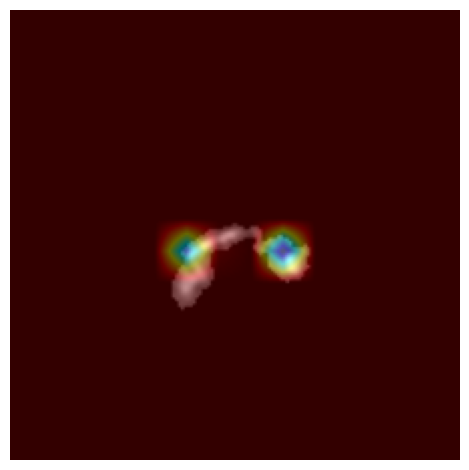

In [12]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit

state_dict = torch.load(trainer.checkpoint_callback.best_model_path)['state_dict']
new_state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}

model.load_state_dict(new_state_dict)

target_layers = [model.encoder.layers.encoder_layer_11.ln_1]

img = Image.open("100_08 41 32.00-02 03 19.7.png")
img = img.convert("RGB")

# normalize the image
transform = albumentations.Compose(
    [
        albumentations.Resize(224, 224),
        albumentations.Normalize(
            mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2(),
    ]
)
img = transform(image=np.array(img))["image"]
input_tensor = img.unsqueeze(0)

out = model(input_tensor)
pred = out.squeeze(0).argmax().item()

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(pred)]

# Construct the CAM object once, and then re-use it on many images.
cam =  GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
img = Image.open("100_08 41 32.00-02 03 19.7.png").convert("RGB")
img = img.resize((224, 224))
# Convert PIL image to NumPy array (range [0, 1])
img_np = np.array(img, dtype=np.float32) / 255.0 
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img_np, grayscale_cam, image_weight= 0.6)
model_outputs = cam.outputs

plt.imshow(visualization); plt.axis('off'); plt.tight_layout(); plt.savefig(f"{hparams['model_name']}_WAT.png", dpi=300, bbox_inches="tight"); plt.show();

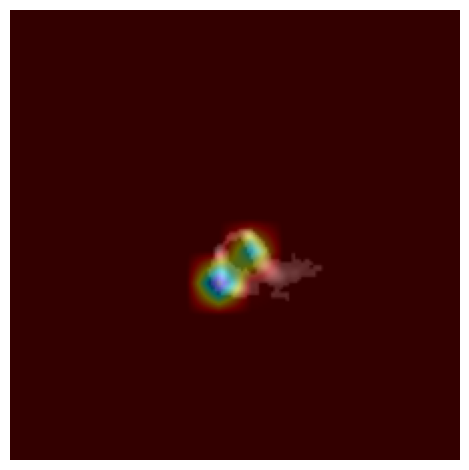

In [13]:
state_dict = torch.load(trainer.checkpoint_callback.best_model_path)['state_dict']
new_state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}

model.load_state_dict(new_state_dict)

target_layers = [model.encoder.layers.encoder_layer_11.ln_1]

img = Image.open("200_07 38 49.51+41 59 07.5.png")
img = img.convert("RGB")

# normalize the image
transform = albumentations.Compose(
    [
        albumentations.Resize(224, 224),
        albumentations.Normalize(
            mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2(),
    ]
)
img = transform(image=np.array(img))["image"]
input_tensor = img.unsqueeze(0)

out = model(input_tensor)
pred = out.squeeze(0).argmax().item()

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(pred)]

cam =  GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
img = Image.open("200_07 38 49.51+41 59 07.5.png").convert("RGB")
img = img.resize((224, 224))
# Convert PIL image to NumPy array (range [0, 1])
img_np = np.array(img, dtype=np.float32) / 255.0 
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img_np, grayscale_cam, image_weight= 0.6)
model_outputs = cam.outputs

plt.imshow(visualization); plt.axis('off'); plt.tight_layout(); plt.savefig(f"{hparams['model_name']}_NAT.png", dpi=300, bbox_inches="tight"); plt.show();

In [14]:
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from pytorch_grad_cam.ablation_layer import AblationLayerVit

# state_dict = torch.load(trainer.checkpoint_callback.best_model_path)['state_dict']
# new_state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}

# model.load_state_dict(new_state_dict)

# target_layers = [model.features[-1]]

# img = Image.open("100_08 41 32.00-02 03 19.7.png")
# img = img.convert("RGB")

# # normalize the image
# transform = albumentations.Compose(
#     [
#         albumentations.Resize(224, 224),
#         albumentations.Normalize(
#             mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
#         ),
#         ToTensorV2(),
#     ]
# )
# img = transform(image=np.array(img))["image"]
# input_tensor = img.unsqueeze(0)

# out = model(input_tensor)
# pred = out.squeeze(0).argmax().item()

# # We have to specify the target we want to generate the CAM for.
# targets = [ClassifierOutputTarget(pred)]

# # Construct the CAM object once, and then re-use it on many images.
# cam =  GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
# img = Image.open("100_08 41 32.00-02 03 19.7.png").convert("RGB")
# img = img.resize((224, 224))
# # Convert PIL image to NumPy array (range [0, 1])
# img_np = np.array(img, dtype=np.float32) / 255.0 
# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(img_np, grayscale_cam, image_weight= 0.6)
# model_outputs = cam.outputs

# plt.imshow(visualization); plt.axis('off'); plt.tight_layout(); plt.savefig(f"{hparams['model_name']}_WAT.png", dpi=300, bbox_inches="tight"); plt.show();

In [ ]:
# state_dict = torch.load(trainer.checkpoint_callback.best_model_path)['state_dict']
# new_state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}

# model.load_state_dict(new_state_dict)

# target_layers = [model.features[-1]]

# img = Image.open("200_07 38 49.51+41 59 07.5.png")
# img = img.convert("RGB")

# # normalize the image
# transform = albumentations.Compose(
#     [
#         albumentations.Resize(224, 224),
#         albumentations.Normalize(
#             mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
#         ),
#         ToTensorV2(),
#     ]
# )
# img = transform(image=np.array(img))["image"]
# input_tensor = img.unsqueeze(0)

# out = model(input_tensor)
# pred = out.squeeze(0).argmax().item()

# # We have to specify the target we want to generate the CAM for.
# targets = [ClassifierOutputTarget(pred)]

# cam =  GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
# img = Image.open("200_07 38 49.51+41 59 07.5.png").convert("RGB")
# img = img.resize((224, 224))
# # Convert PIL image to NumPy array (range [0, 1])
# img_np = np.array(img, dtype=np.float32) / 255.0 
# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(img_np, grayscale_cam, image_weight= 0.6)
# model_outputs = cam.outputs

# plt.imshow(visualization); plt.axis('off'); plt.tight_layout(); plt.savefig(f"{hparams['model_name']}_NAT.png", dpi=300, bbox_inches="tight"); plt.show();